### facenet-pytorch AIHub family dataset evaluation
This notebook demonstrates how to evaluate performance against the LFW dataset.

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face

In [2]:
from fpt.data import join_face_df
from fpt.path import FACE, DTFR, UTIL

In [35]:
face = join_face_df(DTFR, 'aihub_family')
face = face.loc[:,['path', 'target']]


In [4]:
TARGET = UTIL / "model/facenet/data/embedding"

In [5]:
DATASET_CATEGORY = "aihub_family"
CATEGORY = "Family"
data_dir = FACE / f"training_{DATASET_CATEGORY}"
pairs_path = UTIL / "dataset/pairs" / f"pairs_{CATEGORY}.txt"
assert os.path.exists(pairs_path)

batch_size = 16
epochs = 15
workers = 0 if os.name == "nt" else 4

In [ ]:
crop_paths = []
for root, dirs, paths in os.walk(data_dir, followlinks=True):
    if not paths: 
        continue
    for p in paths:
        crop_paths.append(os.path.join(root, p))

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [8]:
# create dataset and data loaders from cropped images output from MTCNN

trans = transforms.Compose(
    [
        transforms.Resize((160, 160)),
        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization,
    ]
)

dataset = datasets.ImageFolder(str(data_dir), transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset),
)

In [9]:
# Load pretrained resnet model
resnet = InceptionResnetV1(classify=False, pretrained="vggface2").to(device)

In [10]:
classes = []
embeddings = []
resnet.eval()
with torch.no_grad():
    for xb, yb in tqdm(embed_loader):
        break
        xb = xb.to(device)
        b_embeddings = resnet(xb)
        b_embeddings = b_embeddings.to("cpu").numpy()
        classes.extend(yb.numpy())
        embeddings.extend(b_embeddings)

100%|██████████| 6842/6842 [24:37<00:00,  4.63it/s] 


In [76]:
# 120.4s, (109469, 512)
# np.savetxt(TARGET / "aihub.txt", np.stack(embeddings))
# np.savetxt(TARGET / "aihub_classes.txt", np.stack(classes))
embeddings = np.loadtxt(TARGET / "aihub.txt")  
classes = np.loadtxt(TARGET / "aihub_classes.txt")

In [ ]:
# with open(TARGET / "aihub_crop_paths.txt", "w") as f:
#     for row in crop_paths:
#         f.write(row)
#         f.write("\n")
        
with open(TARGET / "aihub_crop_paths.txt", "r") as f:
    out = f.readlines()
    crop_paths = [row.rstrip() for row in out]
    crop_paths = [Path(p).stem for p in crop_paths]

In [53]:
embeddings_dict = dict(zip(crop_paths, embeddings))

#### Evaluate embeddings by using distance metrics to perform verification on the official LFW test set.

The functions in the next block are copy pasted from `facenet.src.lfw`. Unfortunately that module has an absolute import from `facenet`, so can't be imported from the submodule

added functionality to return false positive and false negatives

In [80]:
from sklearn.model_selection import KFold
from scipy import interpolate
import math

# LFW functions taken from David Sandberg's FaceNet implementation
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric  # type:ignore

    return dist

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean

def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / max(float(n_same), 1e-10)
    far = float(false_accept) / max(float(n_diff), 1e-10)
    return val, far



def evaluate(embeddings, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn

def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

def get_paths(pairs):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = face.iloc[int(pair[1])].path
            path1 = face.iloc[int(pair[2])].path
            issame = True
        elif len(pair) == 4:
            path0 = face.iloc[int(pair[1])].path
            path1 = face.iloc[int(pair[3])].path
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)

    return path_list, issame_list

def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

In [81]:
pairs = read_pairs(pairs_path)
path_list, issame_list = get_paths(pairs)
embeddings = np.array([embeddings_dict[Path(path).stem] for path in path_list])

tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings, issame_list)

In [82]:
print(accuracy)
np.mean(accuracy)

[0.72333333 0.70166667 0.69166667 0.68       0.67833333 0.71166667
 0.71166667 0.69833333 0.70166667 0.73      ]


0.7028333333333334

#### Visualization

In [83]:
embeddings1 = embeddings[0::2]
embeddings2 = embeddings[1::2]
distances = distance(embeddings1, embeddings2, distance_metric=0)

In [84]:
lfw_matched_dist = distances[issame_list]
lfw_mismatched_dist = distances[np.invert(issame_list)]
print(f"mean matched dist:\t{lfw_matched_dist.mean():5.4f}\n\
mean mismatched dist:\t{lfw_mismatched_dist.mean():5.4f}")

mean matched dist:	0.8501
mean mismatched dist:	1.2459


In [85]:
x = np.stack([lfw_matched_dist, lfw_mismatched_dist])

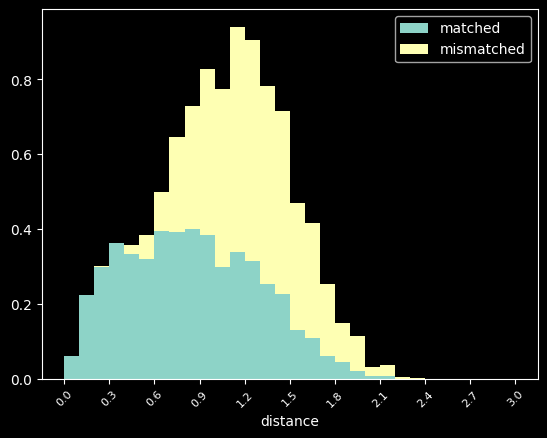

In [86]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(x.T, 30, density=True, histtype="bar", stacked=True,
        range=(0, 3))
ax.set_xlabel('distance')
ax.set_xticks(np.arange(0,3.1,0.3))
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.legend(labels=['matched', 'mismatched'])